In [1]:
# import packages that will be used for plotting and analyzing the data

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
%matplotlib inline

from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import Imputer

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

In [2]:
# read in the data file for analysis

df = pd.read_csv('Data_Files/df_household_clean.csv', low_memory=False)
df.head()

,CONTROL,total_rooms,housing_cost,monthly_rent,garage,num_dining,num_laundry,gut_rehab,is_condo,stairs_broken,...,roach,sewerbreakdowns,fuse_blow,home_better_than_last,nh_better_than_last,manager_onsite,adequacy,hud_subsidized,number_upkeep_probs,num_bathrooms
0,11000001,7,1250 to 1499,NaN,Yes,1,0,No,No,NaN,...,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,NaN,NaN,NaN,Adequate,NaN,Less than 3 upkeep problems,2.5 bathrooms
1,11000002,7,1500 to 1999,NaN,Yes,0,0,NaN,No,No,...,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,NaN,NaN,NaN,Adequate,NaN,Less than 3 upkeep problems,2.5 bathrooms
2,11000005,8,700 to 799,NaN,Yes,1,2,No,No,NaN,...,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,NaN,NaN,NaN,Moderately Inadequate,NaN,3 or 4 upkeep problems,3 bathrooms
3,11000007,8,1500 to 1999,NaN,Yes,1,1,Yes,No,NaN,...,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,NaN,NaN,NaN,Moderately Inadequate,NaN,3 or 4 upkeep problems,2.5 bathrooms
4,11000010,5,450 to 499,370.0,No,0,0,NaN,No,NaN,...,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,NaN,NaN,NaN,Adequate,Public housing tenants and tenants in privatel...,Less than 3 upkeep problems,1.5 bathrooms


In [3]:
# check DataFrame to see if any columns have too many nulls

df.isnull().sum()

CONTROL                      0
total_rooms                  0
housing_cost                 0
monthly_rent             34868
garage                      36
num_dining                   0
num_laundry                  0
gut_rehab                27849
is_condo                     0
stairs_broken            44410
stairs                   29253
musty                    29276
rating_house                 0
rating_neighborhood          0
petty_crime               1007
near_transit              2165
risk_of_flood              579
good_schools              5062
serious_crime              690
subdivision              18930
tenure                       0
porch                        0
out_water_leaks             79
in_water_leaks              75
toilet_broke               105
paint_peeling                0
rent_control             54727
rent_subsidy             34270
near_abandoned             291
near_bar_windows           793
                         ...  
kitchen_exclusive        42579
fridge  

In [4]:
# Remove columns with too many null values. In this case, columns with more than 30% null values are removed.

df=df.dropna(axis=1, how='all', thresh=len(df)*.7)

In [5]:
# create column in DataFrame for target variable. 0 means a rating of 1 to 5, and 1 means a rating of 6 - 10

rating_house_bin = [0 if i <=5 else 1 for i in df['rating_house']]

df['rating_house_bin'] = rating_house_bin


In [6]:
# drop the rating columns from the DataFrame

X = df.drop(['rating_house', 'rating_house_bin'], axis=1)
y = df.rating_house_bin


# create DataFrame X_num which holds all of the numerical values from the original DataFrame

X_num = X.select_dtypes(include=[np.number])
X_num = X_num.drop('CONTROL', axis=1)
X_num.head()


,total_rooms,num_dining,num_laundry,rating_neighborhood,hh_age,year_moved_in,num_people,year_built,stories,unit_floors,num_bedrooms,num_kitchens
0,7,1,0,10.0,49.0,2000.0,3.0,2000,2,2.0,3,1
1,7,0,0,10.0,77.0,2005.0,2.0,2000,2,2.0,3,1
2,8,1,2,8.0,69.0,1995.0,3.0,1970,1,1.0,4,1
3,8,1,1,7.0,49.0,1997.0,4.0,1960,3,3.0,4,1
4,5,0,0,5.0,71.0,2005.0,1.0,1970,1,1.0,3,1


In [7]:
y.value_counts()

1    53283
0     4950
Name: rating_house_bin, dtype: int64

In [8]:
# use sklearn's Imputer to impute missing values in X_num using the mean of every column

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_num)
X_num = imp.transform(X_num)
X_num = pd.DataFrame(X_num)
X_num.columns = ['total_rooms', 'num_dining', 'num_laundry', 'rating_neighborhood', 'hh_age', 'year_moved_in', 'num_people', 'year_built', 'stories', 'unit_floors', 'num_bedrooms', 'num_kitchens']

X_num.head()

,total_rooms,num_dining,num_laundry,rating_neighborhood,hh_age,year_moved_in,num_people,year_built,stories,unit_floors,num_bedrooms,num_kitchens
0,7.0,1.0,0.0,10.0,49.0,2000.0,3.0,2000.0,2.0,2.0,3.0,1.0
1,7.0,0.0,0.0,10.0,77.0,2005.0,2.0,2000.0,2.0,2.0,3.0,1.0
2,8.0,1.0,2.0,8.0,69.0,1995.0,3.0,1970.0,1.0,1.0,4.0,1.0
3,8.0,1.0,1.0,7.0,49.0,1997.0,4.0,1960.0,3.0,3.0,4.0,1.0
4,5.0,0.0,0.0,5.0,71.0,2005.0,1.0,1970.0,1.0,1.0,3.0,1.0


In [9]:
# select categorical features from the DataFrame

X_cat = X.select_dtypes(include=[object])
X_cat.head()


,housing_cost,garage,is_condo,petty_crime,near_transit,risk_of_flood,good_schools,serious_crime,tenure,porch,...,windows_boarded,windows_broken,windows_barred,rodent,roach,sewerbreakdowns,fuse_blow,adequacy,number_upkeep_probs,num_bathrooms
0,1250 to 1499,Yes,No,Disagree,Disagree,Disagree,Agree,Disagree,Owned or being bought by someone in your house...,Yes,...,No,No,No,No signs in the last 12 months,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,Adequate,Less than 3 upkeep problems,2.5 bathrooms
1,1500 to 1999,Yes,No,Disagree,Agree,Disagree,Agree,Disagree,Owned or being bought by someone in your house...,Yes,...,No,No,No,No signs in the last 12 months,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,Adequate,Less than 3 upkeep problems,2.5 bathrooms
2,700 to 799,Yes,No,Disagree,Disagree,Disagree,Agree,Disagree,Owned or being bought by someone in your house...,Yes,...,No,No,No,Seen a few times in the last 12 months,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,Moderately Inadequate,3 or 4 upkeep problems,3 bathrooms
3,1500 to 1999,Yes,No,Agree,Disagree,Disagree,Disagree,Agree,Owned or being bought by someone in your house...,Yes,...,No,No,No,Seen a few times in the last 12 months,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,Moderately Inadequate,3 or 4 upkeep problems,2.5 bathrooms
4,450 to 499,No,No,Agree,Disagree,Disagree,Agree,Disagree,Rented,Yes,...,No,No,No,No signs in the last 12 months,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,Adequate,Less than 3 upkeep problems,1.5 bathrooms


In [10]:
# fill the missing values in X_cat with most common value

for column in X_cat:
    X_cat[column] = X_cat[column].fillna(X_cat[column].value_counts().index[0])


C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
X_cat.isnull().sum()

housing_cost           0
garage                 0
is_condo               0
petty_crime            0
near_transit           0
risk_of_flood          0
good_schools           0
serious_crime          0
tenure                 0
porch                  0
out_water_leaks        0
in_water_leaks         0
toilet_broke           0
paint_peeling          0
near_abandoned         0
near_bar_windows       0
near_trash             0
interview_lang         0
metro_area             0
bldg_type              0
partner_household      0
household_type         0
hoa                    0
unit_size              0
fridge                 0
dishwash               0
washer                 0
dryer                  0
fireplace              0
too_cold               0
no_running_water       0
wall_crack             0
floor_hole             0
foundation_crumb       0
missing_shingle        0
roof_hole              0
roof_sag               0
missing_siding         0
wall_slope             0
windows_boarded        0


In [12]:
X_cat_dummies = pd.get_dummies(X.select_dtypes(include=[object]))
X_cat_dummies.head()

,housing_cost_0 to 99,housing_cost_100 to 199,housing_cost_1000 to 1249,housing_cost_1250 to 1499,housing_cost_1500 to 1999,housing_cost_200 to 249,housing_cost_2000 to 2499,housing_cost_250 to 299,housing_cost_2500 or more,housing_cost_300 to 349,...,num_bathrooms_1.5 bathrooms,num_bathrooms_2 bathrooms,num_bathrooms_2.5 bathrooms,num_bathrooms_3 bathrooms,num_bathrooms_More than 3 bathrooms,num_bathrooms_No full bath: Sink and toilet present,num_bathrooms_No full bath: Toilet only,num_bathrooms_No full bath: Tub and toilet present,num_bathrooms_No full bath: Tub only,num_bathrooms_One full bathroom
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [13]:
X_encoded= X_num.join(X_cat_dummies, how='left')
X_encoded.head()

,total_rooms,num_dining,num_laundry,rating_neighborhood,hh_age,year_moved_in,num_people,year_built,stories,unit_floors,...,num_bathrooms_1.5 bathrooms,num_bathrooms_2 bathrooms,num_bathrooms_2.5 bathrooms,num_bathrooms_3 bathrooms,num_bathrooms_More than 3 bathrooms,num_bathrooms_No full bath: Sink and toilet present,num_bathrooms_No full bath: Toilet only,num_bathrooms_No full bath: Tub and toilet present,num_bathrooms_No full bath: Tub only,num_bathrooms_One full bathroom
0,7.0,1.0,0.0,10.0,49.0,2000.0,3.0,2000.0,2.0,2.0,...,0,0,1,0,0,0,0,0,0,0
1,7.0,0.0,0.0,10.0,77.0,2005.0,2.0,2000.0,2.0,2.0,...,0,0,1,0,0,0,0,0,0,0
2,8.0,1.0,2.0,8.0,69.0,1995.0,3.0,1970.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0
3,8.0,1.0,1.0,7.0,49.0,1997.0,4.0,1960.0,3.0,3.0,...,0,0,1,0,0,0,0,0,0,0
4,5.0,0.0,0.0,5.0,71.0,2005.0,1.0,1970.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,0


At this point, we have dropped all of the features with too many null values, imputed the other missing values, and encoded all of the categorical features into dummy variables.

In [14]:
# split X_cat into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)


## Setting Up a Baseline: A Naive Model
First, a naive model that uses no machine learning will be set up. Since the majority of respondents are satisfied with their housing, let's see how well we do if we predict that every response is the modal response, or 1.

In [15]:
dummy_model = DummyClassifier(strategy='most_frequent')

dummy_model.fit(X_train, y_train)

y_pred_dummy = dummy_model.predict(X_test)

In [40]:
# create a function to print the model metrics

def print_model_metrics(true_values, predicted_values):
    
    # print a confusion matrix
    print(confusion_matrix(true_values, predicted_values))
    print()
    
    # print a classification report
    print(classification_report(true_values, predicted_values))

In [17]:
print_model_metrics(y_test, y_pred_dummy)

[[    0  1449]
 [    0 16021]]

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1449
          1       0.92      1.00      0.96     16021

avg / total       0.84      0.92      0.88     17470

Accuracy Score: 0.92


C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
# create a function to generate and label an ROC curve

def generate_roc_curve(model, X_values, y_values):
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_values)[:,1]
    
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    print("Area Under Curve: {}".format(roc_auc_score(y_test, y_pred_prob)))

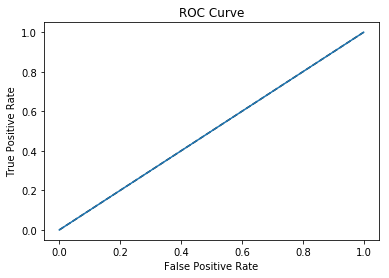

Area Under Curve: 0.5


In [19]:
generate_roc_curve(dummy_model, X_test, y_test)

## Model 1: Out of the Box Logistic Regression

This model is trained using sklearn's LogisticRegression on 70% of the entire dataset, which has over 58,000 values.

In [20]:
logreg_1 = LogisticRegression()
logreg_1.fit(X_train, y_train)

y_pred = logreg_1.predict(X_test)

print_model_metrics(y_test, y_pred)

[[  396  1053]
 [  227 15794]]

             precision    recall  f1-score   support

          0       0.64      0.27      0.38      1449
          1       0.94      0.99      0.96     16021

avg / total       0.91      0.93      0.91     17470

Accuracy Score: 0.93


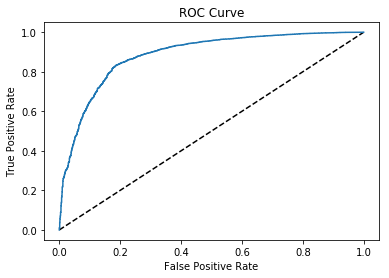

Area Under Curve: 0.8849470301423308


In [21]:
generate_roc_curve(logreg_1, X_test, y_test)

Using the out of the box logistic regression model attains a fairly high f1 score of 0.96 for predicting the 1 class, but only a score of o.38 for for 0 class. Cross-validation will be used to tune the model's hyperparameters to see if the model's performance can be improved further.

## Model 2: Tuned Logistic Regresstion

In this model, several values of the hyperparameter, C, are tested using cross-validation.

In [22]:
#Setup the hyperparameter grid
c_space = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': c_space}

logreg_cv = GridSearchCV(logreg_1, param_grid, cv=5)


In [23]:

logreg_cv.fit(X_train, y_train)

# print best parameters from cross validation
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 100}
Tuned Logistic Regression Accuracy: 0.9249809876603783


The best C value is 100, so the next model will be initialized with C=100

In [24]:
# Instantiate a logistic regression classifier using the best parameter from cross validation: logreg

logreg_tuned = LogisticRegression(C=100)
logreg_tuned.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
# generate predictions for test set and evaluate its performance

y_pred = logreg_tuned.predict(X_test)

print_model_metrics(y_test, y_pred)

[[  396  1053]
 [  227 15794]]

             precision    recall  f1-score   support

          0       0.64      0.27      0.38      1449
          1       0.94      0.99      0.96     16021

avg / total       0.91      0.93      0.91     17470

Accuracy Score: 0.93


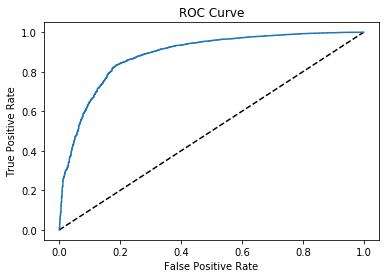

Area Under Curve: 0.8849476762921888


In [26]:
generate_roc_curve(logreg_tuned, X_test, y_test)

The performance of the model hasn't increased by much even after tuning the hyperparameter. We can also try to use feature selection to see if reducing the model's complexity will improve its performance. 

## Model 3: Tuned Logistic Regression Using Feature Selection


In [27]:
test = SelectKBest(score_func=chi2, k=50)
fit = test.fit(X_encoded, rating_house_bin)

mask = test.get_support()
new_features = X_encoded.columns[mask]
new_features

Index(['total_rooms', 'rating_neighborhood', 'hh_age', 'num_bedrooms',
       'garage_No', 'garage_Yes', 'petty_crime_Agree', 'petty_crime_Disagree',
       'good_schools_Disagree', 'serious_crime_Agree',
       'tenure_Owned or being bought by someone in your household',
       'tenure_Rented', 'porch_No', 'out_water_leaks_Yes',
       'in_water_leaks_Yes', 'toilet_broke_Yes', 'paint_peeling_Yes',
       'near_abandoned_More than one vandalized building',
       'near_bar_windows_More than one building with metal bars',
       'near_trash_Large amount of trash', 'near_trash_Small amount of trash',
       'bldg_type_One-family house, detached',
       'household_type_Female householder, no husband present',
       'household_type_Married-couple family household', 'hoa_Yes',
       'dishwash_No', 'dishwash_Yes', 'washer_No',
       'dryer_Unit does not have a working clothes dryer',
       'fireplace_Has usable fireplace, not considered heating equipment',
       'fireplace_No usable fi

In [28]:
X_masked = X_encoded[new_features]


X_train, X_test, y_train, y_test = train_test_split(X_masked, y, test_size=0.3, random_state=42)

In [29]:

logreg_cv.fit(X_train, y_train)

# print best parameters from cross validation
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logist`ic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 10}
Tuned Logist`ic Regression Accuracy: 0.9246866030468808


In [30]:
logreg_fs = LogisticRegression(C=10)
logreg_fs.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
y_pred = logreg_fs.predict(X_test)

print_model_metrics(y_test, y_pred)

[[  388  1061]
 [  235 15786]]

             precision    recall  f1-score   support

          0       0.62      0.27      0.37      1449
          1       0.94      0.99      0.96     16021

avg / total       0.91      0.93      0.91     17470

Accuracy Score: 0.93


## Model 4: Tuned Logistic Regression with Undersampling

Because the 

In [32]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_sample(X_encoded, y)

In [42]:
print(len(X_res))

9900


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [34]:
logreg_undersample = LogisticRegression()
logreg_undersample.fit(X_train, y_train)

y_pred = logreg_undersample.predict(X_test)

print_model_metrics(y_test, y_pred)

[[1199  311]
 [ 270 1190]]

             precision    recall  f1-score   support

          0       0.82      0.79      0.80      1510
          1       0.79      0.82      0.80      1460

avg / total       0.80      0.80      0.80      2970

Accuracy Score: 0.80


In [35]:
#Setup the hyperparameter grid
c_space = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': c_space}

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)


logreg_cv.fit(X_train, y_train)

# print best parameters from cross validation
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameter: {'C': 0.01}
Tuned Logistic Regression Accuracy: 0.8044733044733045


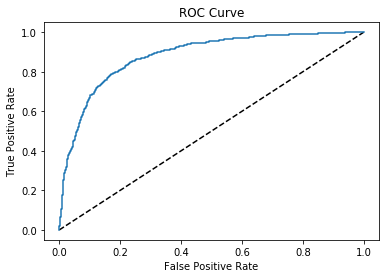

Area Under Curve: 0.8817540596933685


In [36]:
generate_roc_curve(logreg_undersample, X_test, y_test)

## Model 5: Random Forest

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [38]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
y_pred = clf.predict(X_test)

print_model_metrics(y_test, y_pred)

[[  423  1026]
 [  363 15658]]

             precision    recall  f1-score   support

          0       0.54      0.29      0.38      1449
          1       0.94      0.98      0.96     16021

avg / total       0.91      0.92      0.91     17470

Accuracy Score: 0.92


A random forest did no better than a logistic regression model.

## Model 6: Random Forest with Tuned Hyperparameters
